In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

In [3]:
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'

In [4]:
import voxelmorph as vxm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import importlib

In [5]:
class ImageRegistrationDataset(Dataset):
    def __init__(self, pairs_file):
        self.image_pairs = []
        with open(pairs_file, 'r') as file:
            for line in file:
                moving, fixed = line.strip().split()
                self.image_pairs.append((moving, fixed))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        moving_path, fixed_path = self.image_pairs[idx]

        # Load images as numpy arrays
        moving_image = np.load(moving_path)
        fixed_image = np.load(fixed_path)
        moving_image = moving_image/255.0
        fixed_image = fixed_image/255.0


        # Convert numpy arrays to PyTorch tensors and add the batch dimension
        # Also, permute dimensions to match the desired shape: [batch_size, channels, height, width]
        moving_tensor = torch.from_numpy(moving_image).unsqueeze(0).float()
        fixed_tensor = torch.from_numpy(fixed_image).unsqueeze(0).float()

        return [moving_tensor, fixed_tensor], [fixed_tensor]
        #If bidir:
        #return [moving_tensor, fixed_tensor], [fixed_tensor, moving_tensor]

Inputs Length: 2
Inputs[0] Shape: torch.Size([1, 1, 512, 512])
Inputs[1] Shape: torch.Size([1, 1, 512, 512])
y_true Length: 1
y_true[0] Shape: torch.Size([1, 1, 512, 512])
y_true[0][0][0] min_val: 1.0


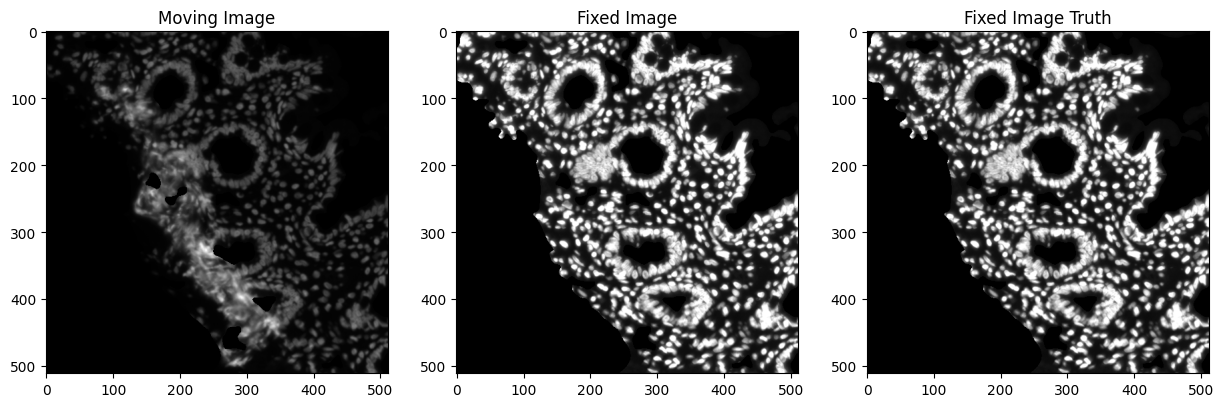

In [6]:
# Initialize dataset
train_dataset = ImageRegistrationDataset('/home-local/rudravg/test_DAPI/new_pairs.txt')
val_dataset = ImageRegistrationDataset('/home-local/rudravg/test_DAPI/new_val_pairs.txt')
# Create data loader with batch_size=1 since you are loading one batch at a time
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
# Example of iterating over the data loader
for inputs, y_true in val_data_loader:
    print(f'Inputs Length: {len(inputs)}')
    print(f'Inputs[0] Shape: {inputs[0].shape}')
    print(f'Inputs[1] Shape: {inputs[1].shape}')
    print(f'y_true Length: {len(y_true)}')
    print(f'y_true[0] Shape: {y_true[0].shape}')
    print(f'y_true[0][0][0] min_val: {y_true[0][0][0].max()}')
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(inputs[0][0].numpy().squeeze(), cmap='gray')
    plt.title('Moving Image')
    plt.subplot(1, 3, 2)
    plt.imshow(inputs[1][0].numpy().squeeze(), cmap='gray')
    plt.title('Fixed Image')
    plt.subplot(1, 3, 3)
    plt.imshow(y_true[0][0].numpy().squeeze(), cmap='gray')
    plt.title('Fixed Image Truth')
    plt.show()

    # Your training logic here
    break

In [7]:
len(train_data_loader)

1356

In [7]:
IN_SHAPE=(512,512)
model=vxm.networks.VxmDense(inshape=IN_SHAPE)

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
model.train()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
image_loss_func=vxm.losses.NCC().loss 
losses=[image_loss_func]
weights=[1]

In [10]:
losses += [vxm.losses.Grad('l2',loss_mult=2).loss]
weights += [0.01]

In [12]:
epoch_loss_final=[]
epoch_val_loss_final=[]
inference_dir='/home-local/rudravg/test_DAPI/epochs_sanity_check/'
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0

for epoch in range(500):
    ########### Training ###########
    model.train()
    epoch_loss=[]
    epoch_total_loss=[]
    val_loss=[]

    for inputs, y_true in train_data_loader:
        inputs = [i.to(device) for i in inputs]
        y_true = [i.to(device) for i in y_true]
        y_pred=model(*inputs)
        loss=0
        loss_list=[]
        for n,loss_function in enumerate(losses):
            curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
            loss_list.append(curr_loss.item())
            loss+=curr_loss
        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss_final.append(np.mean(epoch_total_loss))

    ########### Inference ###########
    with torch.inference_mode():
        epoch_dir = os.path.join(inference_dir, f'epoch_{epoch}')
        os.makedirs(epoch_dir, exist_ok=True)
        model.save(os.path.join(epoch_dir, f'epoch_{epoch}.pth'))
        model.eval()
        i=0
        for inputs, y_true in val_data_loader:
            i+=1
            inputs = [i.to(device) for i in inputs]
            y_true = [i.to(device) for i in y_true]
            y_pred=model(*inputs)
            loss=0
            for n,loss_function in enumerate(losses):
                curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
                loss+=curr_loss
            val_loss.append(loss.item())
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(inputs[0][0].cpu().numpy().squeeze(), cmap='gray')
            plt.title('Moving Image')
            plt.subplot(1, 3, 2)
            plt.imshow(inputs[1][0].cpu().numpy().squeeze(), cmap='gray')
            plt.title('Fixed Image')
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[0][0].detach().cpu().numpy().squeeze(), cmap='gray')
            plt.title('Registered Image')
            plt.savefig(os.path.join(epoch_dir, f'pair_{i}.png'))  # Save the plot as an image
            plt.close()
        epoch_val_loss_final.append(np.mean(val_loss))
    mean_val_loss = np.mean(val_loss)
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print(f'Early stopping on epoch {epoch}')
        break
    print('------------------------------------------------------')
    print(f'Epoch: {epoch} Loss: {np.mean(epoch_total_loss)}')
    print(f'Epoch {epoch} Val Loss: {np.mean(val_loss)}')
    print(f'Epoch {epoch} Losses: {np.mean(epoch_loss, axis=0)}')
    print('------------------------------------------------------')

------------------------------------------------------
Epoch: 0 Loss: -0.15715570881810834
Epoch 0 Val Loss: -0.15665039851112253
Epoch 0 Losses: [-1.57163168e-01  7.45932879e-06]
------------------------------------------------------
------------------------------------------------------
Epoch: 1 Loss: -0.18568760526207728
Epoch 1 Val Loss: -0.22006621129781087
Epoch 1 Losses: [-1.85697549e-01  9.94390319e-06]
------------------------------------------------------
------------------------------------------------------
Epoch: 2 Loss: -0.20766488580856596
Epoch 2 Val Loss: -0.21800484207082302
Epoch 2 Losses: [-2.07676833e-01  1.19466800e-05]
------------------------------------------------------
------------------------------------------------------
Epoch: 3 Loss: -0.21368667082595139
Epoch 3 Val Loss: -0.2332336504936238
Epoch 3 Losses: [-2.13699308e-01  1.26373912e-05]
------------------------------------------------------
------------------------------------------------------
Epoch:

KeyboardInterrupt: 

In [1]:
#Get the minimum index of epoch_val_loss_final
epoch_loss_final.index(min(epoch_loss_final))

NameError: name 'epoch_loss_final' is not defined

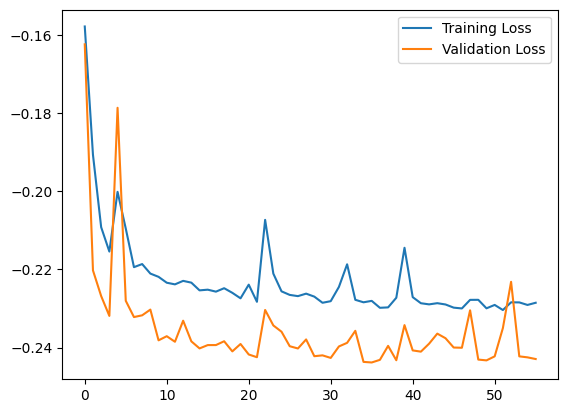

In [23]:
#Plot the training and validation loss
plt.plot(epoch_loss_final, label='Training Loss')
plt.plot(epoch_val_loss_final, label='Validation Loss')
plt.legend()


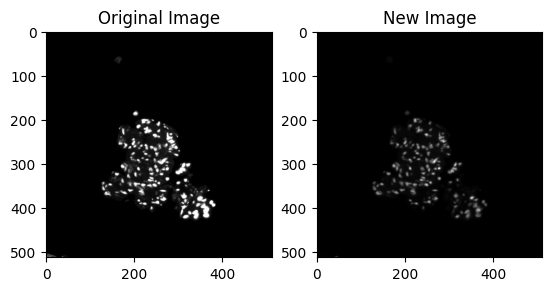

In [4]:
#Load a numpy image and plot it
orig_image = np.load('/home-local/rudravg/test_DAPI/target_images/GCA112TIA_DAPI_00_0_1024.npy')
new_image = np.load('/home-local/rudravg/test_DAPI/source_images/GCA112TIA_DAPI_19_0_1024.npy')
orig_image=orig_image/255.0
new_image=new_image/255.0
plt.subplot(1, 2, 1)
plt.imshow(orig_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(new_image, cmap='gray')
plt.title('New Image')

plt.show()
# Save the original image
plt.imsave('/home-local/rudravg/test_DAPI/testing_it_out/original_image.png', orig_image, cmap='gray')
np.save('/home-local/rudravg/test_DAPI/testing_it_out/original_image.npy', orig_image)

# Save the new image
plt.imsave('/home-local/rudravg/test_DAPI/testing_it_out/new_image.png', new_image, cmap='gray')
np.save('/home-local/rudravg/test_DAPI/testing_it_out/new_image.npy', new_image)

In [6]:
device=torch.device('cuda')
best_model_path='/home-local/rudravg/test_DAPI/epochs/epoch_35/epoch_35.pth'
best_model=vxm.networks.VxmDense.load(best_model_path, device)
best_model.to(device)
best_model.eval()

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [8]:
from tqdm import tqdm
before_reg=[]
after_reg=[]
# Open the file
with open('/home-local/rudravg/test_DAPI/new_val_pairs.txt', 'r') as f:
    # Read the lines
    lines = f.readlines()

# Iterate over the lines
for line in tqdm(lines):
    # Split the line into moving_file and fixed_file
    moving_file, fixed_file = line.strip().split(' ')
    moving_image = (np.load(moving_file))/255.0
    fixed_image = (np.load(fixed_file))/255.0
    np.save('/home-local/rudravg/test_DAPI/testing_it_out/moving_image.npy', moving_image)
    np.save('/home-local/rudravg/test_DAPI/testing_it_out/fixed_image.npy', fixed_image)
    mov_file='/home-local/rudravg/test_DAPI/testing_it_out/moving_image.npy'
    fix_file='/home-local/rudravg/test_DAPI/testing_it_out/fixed_image.npy'
    moving=vxm.py.utils.load_volfile(mov_file,add_batch_axis=True,add_feat_axis=True)
    fixed,fixed_affine=vxm.py.utils.load_volfile(fix_file,add_batch_axis=True,add_feat_axis=True,ret_affine=True)
    input_moving=torch.from_numpy(moving).to(device).float().permute(0,3,1,2)
    input_fixed=torch.from_numpy(fixed).to(device).float().permute(0,3,1,2)
    ncc_val_before=vxm.losses.NCC().loss(input_fixed,input_moving).item()
    before_reg.append(abs(ncc_val_before))
    moved,warp=best_model(input_moving,input_fixed,registration=True)
    ncc_val_after=vxm.losses.NCC().loss(input_fixed,moved).item()
    after_reg.append(abs(ncc_val_after))
    #Save moving_image and fixed_image as numpy arrays

100%|██████████| 102/102 [00:01<00:00, 75.68it/s]


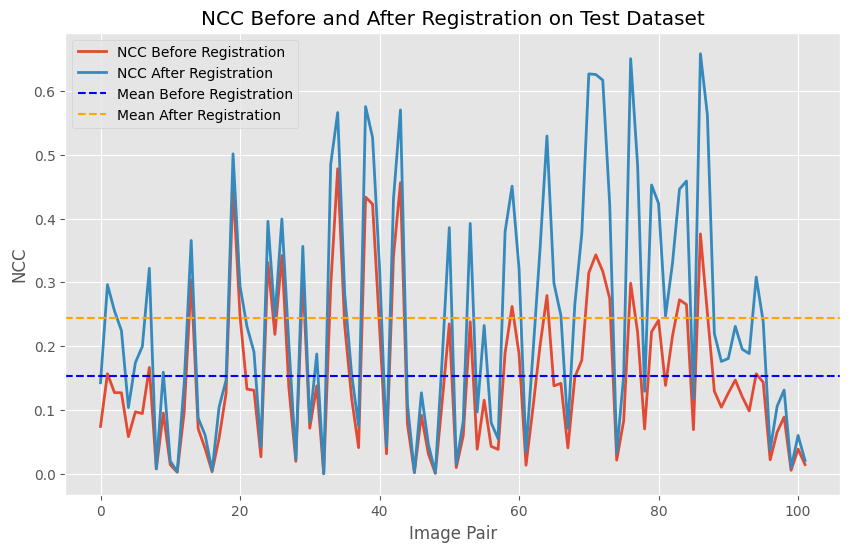

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Use a different style
plt.style.use('ggplot')

# Increase the figure size
plt.figure(figsize=(10, 6))

# Plot the data with increased line width
plt.plot(before_reg, label='NCC Before Registration', linewidth=2)
plt.plot(after_reg, label='NCC After Registration', linewidth=2)

# Plot the mean
plt.axhline(np.mean(before_reg), color='blue', linestyle='--', label='Mean Before Registration')
plt.axhline(np.mean(after_reg), color='orange', linestyle='--', label='Mean After Registration')

# Add title and labels
plt.title('NCC Before and After Registration on Test Dataset')

plt.ylabel('NCC')
plt.xlabel('Image Pair')

# Add a legend
plt.legend()

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

In [43]:
#Print indices where NCC after_reg is less than before_reg
np.where(np.array(after_reg) < np.array(before_reg))

(array([32]),)

In [26]:
#Print the index with minimum value for after_reg
np.argmin(after_reg)

32

In [40]:
print(format(before_reg[32], '.8f'), format(after_reg[32], '.8f'))


0.00032354 0.00008060


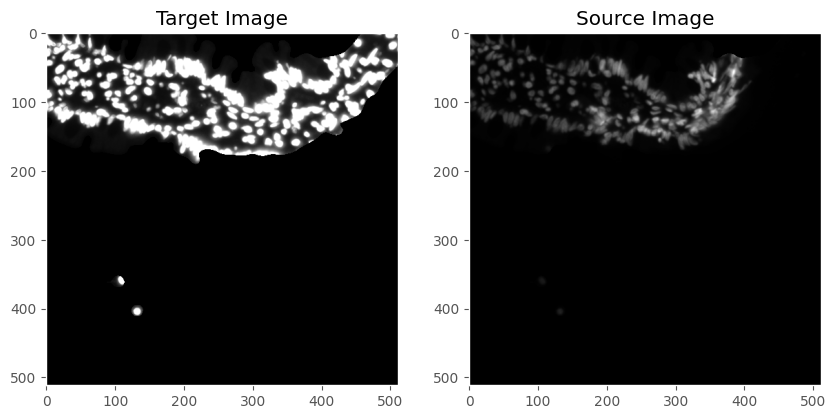

In [33]:

import matplotlib.pyplot as plt
# Load the images
target_image = np.load('/home-local/rudravg/test_DAPI/val_target_images/GCA075TIB_00_2048_2048.npy')
source_image = np.load('/home-local/rudravg/test_DAPI/val_source_images/GCA075TIB_12_2048_2048.npy')

# Create a figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the target image
ax[0].imshow(target_image, cmap='gray')
ax[0].set_title('Target Image')

# Plot the source image
ax[1].imshow(source_image, cmap='gray')
ax[1].set_title('Source Image')

# Hide the grid
ax[0].grid(False)
ax[1].grid(False)
# Display the plot
plt.show()


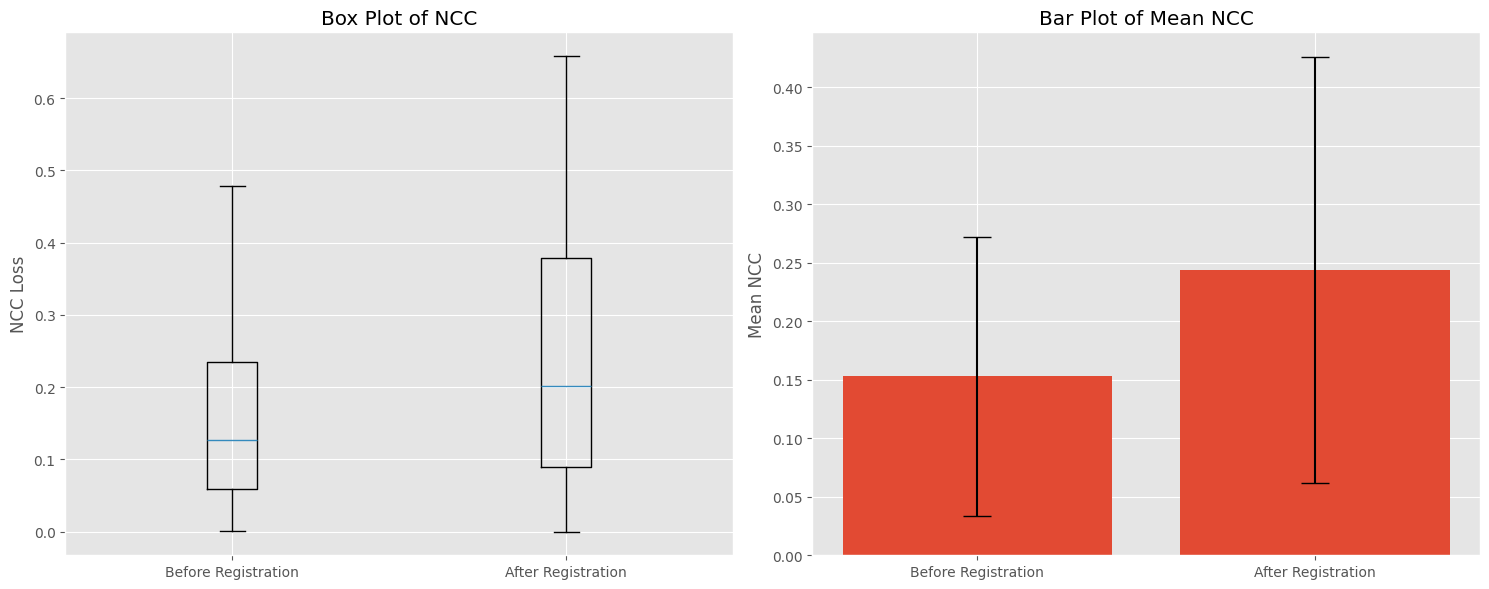

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Create a box plot
axs[0].boxplot([before_reg, after_reg], labels=['Before Registration', 'After Registration'])
axs[0].set_title('Box Plot of NCC')
axs[0].set_ylabel('NCC Loss')

# Create a bar plot
means = [np.mean(before_reg), np.mean(after_reg)]
std_devs = [np.std(before_reg), np.std(after_reg)]
axs[1].bar(['Before Registration', 'After Registration'], means, yerr=std_devs, capsize=10)
axs[1].set_title('Bar Plot of Mean NCC')
axs[1].set_ylabel('Mean NCC')

# Show the plots
plt.tight_layout()
plt.show()

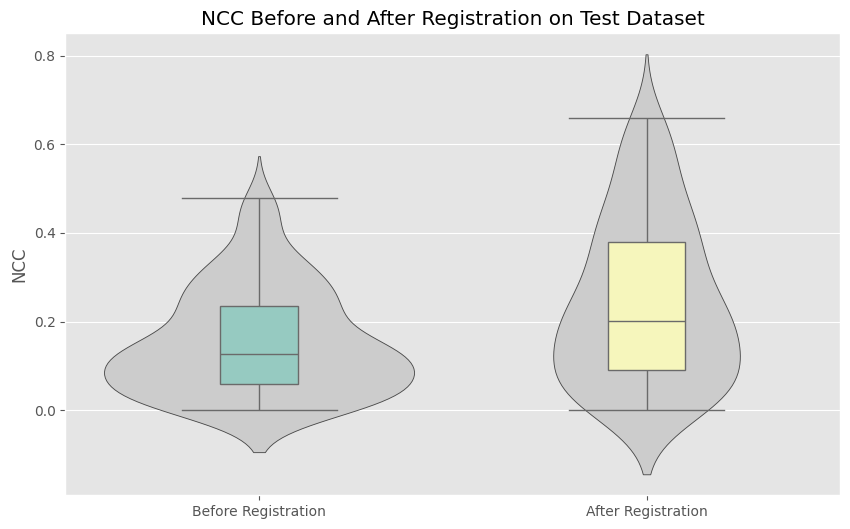

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import numpy as np

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a combined violin plot and box plot
sns.violinplot(data=[before_reg, after_reg], inner=None, color=".8")
sns.boxplot(data=[before_reg, after_reg], widths=.2, palette="Set3")

# Add title and labels
plt.title('NCC Before and After Registration on Test Dataset')
plt.xticks([0, 1], ['Before Registration', 'After Registration'])
plt.ylabel('NCC')


# Show the plot
plt.show()

In [51]:
# Perform the Wilcoxon signed-rank test
w_stat, p_val = wilcoxon(after_reg, before_reg)
axs[0].text(0.5, 0.01, f'Wilcoxon test p-value = {p_val}', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
p_val

1.8777991344421797e-18

In [6]:
moving_file='/home-local/rudravg/test_DAPI/testing_it_out/new_image.npy'
fixed_file='/home-local/rudravg/test_DAPI/testing_it_out/original_image.npy'


In [7]:
moving=vxm.py.utils.load_volfile(moving_file,add_batch_axis=True,add_feat_axis=True)
fixed,fixed_affine=vxm.py.utils.load_volfile(fixed_file,add_batch_axis=True,add_feat_axis=True,ret_affine=True)

In [8]:
input_moving=torch.from_numpy(moving).to(device).float().permute(0,3,1,2)
input_fixed=torch.from_numpy(fixed).to(device).float().permute(0,3,1,2)
input_moving.device,input_fixed.device
ncc_val=vxm.losses.NCC().loss(input_fixed,input_moving).item()
ncc_val

TypeError: NMI.__init__() missing 1 required positional argument: 'bin_centers'

In [25]:
moved,warp=best_model(input_moving,input_fixed,registration=True)
ncc_val2=vxm.losses.NCC().loss(input_fixed,moved).item()
ncc_val2

-0.12465459108352661

In [22]:
moved_img=moved.detach().cpu().numpy().squeeze()

# Save moved_img as a .png file
plt.imsave('/home-local/rudravg/test_DAPI/testing_it_out/moved_img.png', moved_img, cmap='gray')

# Save moved_img as a .npy file
np.save('/home-local/rudravg/test_DAPI/testing_it_out/moved_img.npy', moved_img)